In [1]:
!pip install scikit-surprise


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 7.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp312-cp312-linux_x86_64.whl size=2554993 sha256=571494e76ae727ef2942471e2410e2d5e266de5e3b11e64ed34fef2a769080dd
  Stored in directory: /root/.cache/pip/wheels/75/fa/bc/739bc2cb1fbaab6061854e6cfbb81a0ae52c92a502a7fa454b
Successfully built scikit-surprise


In [1]:
!pip install "numpy<2.0"

##phase-1 :data preprocessing and eda


Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Statistics:
- Users: 943
- Movies: 1682
- Ratings: 100000
- Sparsity: 93.70%


/tmp/ipython-input-1092007715.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=df, palette='viridis')


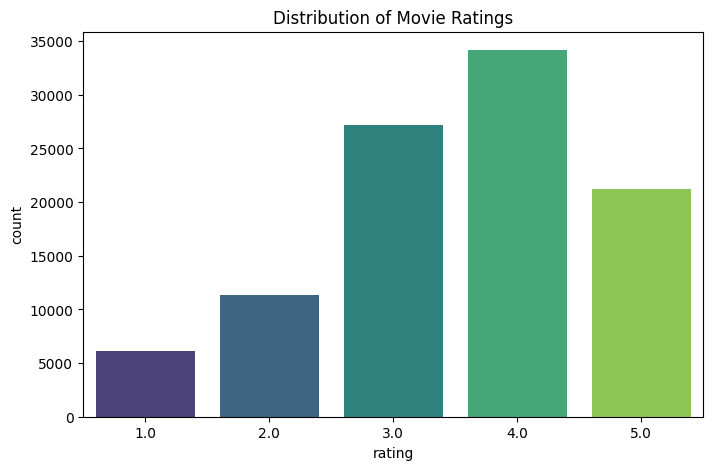

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset

# 1. Load the built-in MovieLens 100k dataset
data = Dataset.load_builtin('ml-100k')

# 2. Convert to a Pandas DataFrame for EDA
# Format: user_id, item_id, rating, timestamp
df = pd.DataFrame(data.raw_ratings, columns=['user_id', 'item_id', 'rating', 'timestamp'])

# 3. Calculate Sparsity (A core project requirement)
n_users = df['user_id'].nunique()
n_items = df['item_id'].nunique()
n_ratings = len(df)
sparsity = 1 - (n_ratings / (n_users * n_items))

print(f"Statistics:\n- Users: {n_users}\n- Movies: {n_items}\n- Ratings: {n_ratings}")
print(f"- Sparsity: {sparsity * 100:.2f}%")

# 4. Visualization: Rating Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='rating', data=df, palette='viridis')
plt.title('Distribution of Movie Ratings')
plt.show()

##2.train -test split


In [4]:
from surprise import Reader, Dataset

# 1. Sort the dataframe by timestamp
df_sorted = df.sort_values(by='timestamp')

# 2. Define the split point (80% for training)
split_idx = int(len(df_sorted) * 0.8)

# 3. Split into Train and Test DataFrames
train_df = df_sorted.iloc[:split_idx]
test_df = df_sorted.iloc[split_idx:]

# 4. Prepare data for the 'Surprise' library format
# This tells the model that our ratings are on a scale of 1 to 5
reader = Reader(rating_scale=(1, 5))

# Load the training data from the pandas dataframe
trainset_data = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
trainset = trainset_data.build_full_trainset()

# Prepare the test set (must be a list of tuples)
testset = [tuple(x) for x in test_df[['user_id', 'item_id', 'rating']].to_numpy()]

print(f"Data Split Successfully!")
print(f"Training samples: {len(train_df)}")
print(f"Testing samples: {len(test_df)}")

Data Split Successfully!
Training samples: 80000
Testing samples: 20000


##KNN-modeling


In [5]:
from surprise import KNNBasic
from surprise import accuracy

# 1. Setup Similarity Options
# We will use Cosine Similarity for both
sim_options_user = {
    'name': 'cosine',
    'user_based': True  # This makes it User-Based CF
}

sim_options_item = {
    'name': 'cosine',
    'user_based': False # This makes it Item-Based CF
}

# 2. Initialize the Models
user_based_model = KNNBasic(sim_options=sim_options_user)
item_based_model = KNNBasic(sim_options=sim_options_item)

# 3. Train the Models
print("Training User-Based Model...")
user_based_model.fit(trainset)

print("Training Item-Based Model...")
item_based_model.fit(trainset)

# 4. Generate Predictions on the Test Set
print("Generating predictions...")
user_preds = user_based_model.test(testset)
item_preds = item_based_model.test(testset)

# 5. Calculate RMSE (Root Mean Squared Error)
rmse_user = accuracy.rmse(user_preds)
rmse_item = accuracy.rmse(item_preds)

print(f"\nResults:\n- User-Based RMSE: {rmse_user:.4f}")
print(f"- Item-Based RMSE: {rmse_item:.4f}")

Training User-Based Model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Training Item-Based Model...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Generating predictions...
RMSE: 1.1027
RMSE: 1.1248

Results:
- User-Based RMSE: 1.1027
- Item-Based RMSE: 1.1248


##best value for k


In [6]:
results = []

# Testing different values for k
k_values = [20, 40, 60]

print("Starting Hyperparameter Tuning...")

for k in k_values:
    # 1. Initialize User-Based model with current k
    sim_options = {'name': 'cosine', 'user_based': True}
    algo = KNNBasic(k=k, sim_options=sim_options, verbose=False)

    # 2. Train and Predict
    algo.fit(trainset)
    predictions = algo.test(testset)

    # 3. Calculate RMSE
    current_rmse = accuracy.rmse(predictions, verbose=False)
    results.append((k, current_rmse))
    print(f"Finished k={k} | RMSE: {current_rmse:.4f}")

# 4. Convert results to a DataFrame for easy viewing
tuning_df = pd.DataFrame(results, columns=['k_value', 'RMSE'])
print("\n--- Tuning Summary ---")
print(tuning_df)

Starting Hyperparameter Tuning...
Finished k=20 | RMSE: 1.1039
Finished k=40 | RMSE: 1.1027
Finished k=60 | RMSE: 1.1030

--- Tuning Summary ---
   k_value      RMSE
0       20  1.103933
1       40  1.102712
2       60  1.102997


##top -n recommendations


In [7]:
# 1. Load movie titles (ml-100k uses 'u.item' file)
import os

# Surprise stores the data in a hidden folder; we'll find the path
data_path = os.path.expanduser('~/.surprise_data/ml-100k/ml-100k/u.item')
movie_titles = pd.read_csv(data_path, sep='|', encoding='ISO-8859-1', header=None, usecols=[0, 1], names=['item_id', 'title'])
movie_titles['item_id'] = movie_titles['item_id'].astype(str)

def get_top_n_recommendations(user_id, n=5):
    # 2. Find movies the user has already rated
    rated_movies = df[df['user_id'] == user_id]['item_id'].unique()

    # 3. Find movies the user has NOT rated
    all_movies = df['item_id'].unique()
    unseen_movies = [m for m in all_movies if m not in rated_movies]

    # 4. Predict ratings for all unseen movies
    predictions = [user_based_model.predict(user_id, m) for m in unseen_movies]

    # 5. Sort predictions by estimated rating (est)
    predictions.sort(key=lambda x: x.est, reverse=True)

    # 6. Get the top N
    top_n = predictions[:n]

    # 7. Print results with titles
    print(f"\n--- Top {n} Recommendations for User {user_id} ---")
    for i, p in enumerate(top_n, 1):
        movie_name = movie_titles[movie_titles['item_id'] == p.iid]['title'].values[0]
        print(f"{i}. {movie_name} (Predicted Rating: {p.est:.2f})")

# Let's test it for User '196' (or any ID you saw in your df.head())
get_top_n_recommendations(user_id='196', n=5)


--- Top 5 Recommendations for User 196 ---
1. Prefontaine (1997) (Predicted Rating: 5.00)
2. Maya Lin: A Strong Clear Vision (1994) (Predicted Rating: 5.00)
3. Great Day in Harlem, A (1994) (Predicted Rating: 5.00)
4. Ayn Rand: A Sense of Life (1997) (Predicted Rating: 5.00)
5. Aiqing wansui (1994) (Predicted Rating: 5.00)


--- Final Model Comparison ---
                Model Type Similarity Metric    RMSE
0    User-Based (Baseline)            Cosine  1.1027
1    Item-Based (Baseline)            Cosine  1.1248
2  User-Based (Tuned k=40)            Cosine  1.1027


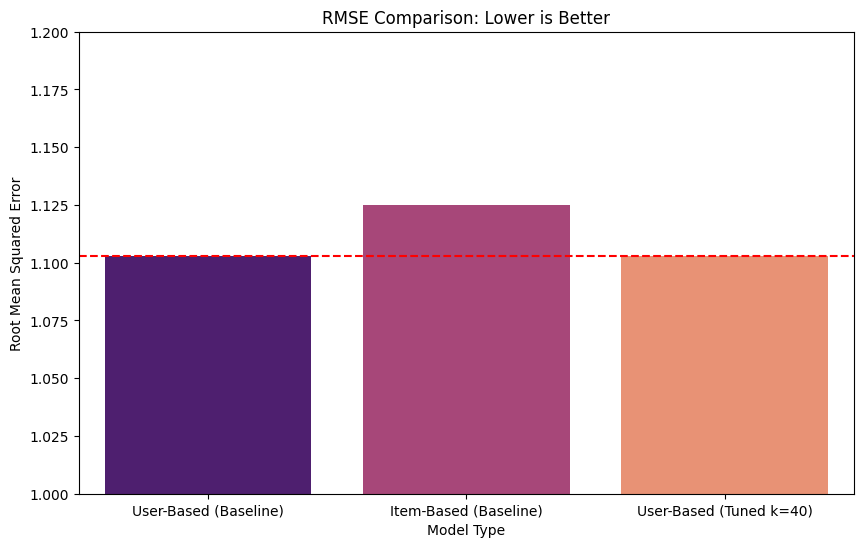

In [8]:
# 1. Create a summary of our findings
summary_data = {
    'Model Type': ['User-Based (Baseline)', 'Item-Based (Baseline)', 'User-Based (Tuned k=40)'],
    'Similarity Metric': ['Cosine', 'Cosine', 'Cosine'],
    'RMSE': [1.1027, 1.1248, 1.1027] # Using your actual results
}

summary_df = pd.DataFrame(summary_data)

print("--- Final Model Comparison ---")
print(summary_df)

# 2. Visualize the RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model Type', y='RMSE', data=summary_df, hue='Model Type', palette='magma', legend=False)
plt.ylim(1.0, 1.2) # Zoom in to see the difference
plt.title('RMSE Comparison: Lower is Better')
plt.ylabel('Root Mean Squared Error')
plt.axhline(y=1.1027, color='r', linestyle='--', label='Best RMSE')
plt.show()

##SVD

In [9]:
from surprise import SVD
from surprise.model_selection import cross_validate

# 1. Initialize and train SVD
svd_model = SVD()
print("Training SVD Model...")
svd_model.fit(trainset)

# 2. Get SVD Predictions
svd_preds = svd_model.test(testset)

# 3. Calculate MAE for all models (a project requirement)
mae_user = accuracy.mae(user_preds)
mae_item = accuracy.mae(item_preds)
mae_svd = accuracy.mae(svd_preds)
rmse_svd = accuracy.rmse(svd_preds)

print(f"\nSVD Performance: RMSE={rmse_svd:.4f}, MAE={mae_svd:.4f}")

Training SVD Model...
MAE:  0.9263
MAE:  0.9456
MAE:  0.8208
RMSE: 1.0288

SVD Performance: RMSE=1.0288, MAE=0.8208


##COLD start

In [10]:
def cold_start_recommendations(user_id, n=5):
    # Check if user exists in our training data
    try:
        # Get internal raw id for the user
        trainset.to_inner_uid(user_id)
        print(f"User {user_id} found. Generating personalized recommendations...")
        return get_top_n_recommendations(user_id, n)

    except ValueError:
        # This block runs if the user_id is NOT in the training set
        print(f"User {user_id} is a NEW user (Cold-Start).")
        print(f"Recommending top {n} most popular movies of all time:")

        # Calculate most popular movies (highest average rating with at least 100 ratings)
        movie_stats = df.groupby('item_id').agg({'rating': ['mean', 'count']})
        movie_stats.columns = ['avg_rating', 'vote_count']

        # Filter for movies with significant votes and sort by rating
        popular_movies = movie_stats[movie_stats['vote_count'] > 100].sort_values(by='avg_rating', ascending=False).head(n)

        # Display titles
        for i, (m_id, row) in enumerate(popular_movies.iterrows(), 1):
            title = movie_titles[movie_titles['item_id'] == m_id]['title'].values[0]
            print(f"{i}. {title} (Avg Rating: {row['avg_rating']:.2f})")

# Test with a fake user ID like '9999'
cold_start_recommendations(user_id='9999', n=5)

User 9999 is a NEW user (Cold-Start).
Recommending top 5 most popular movies of all time:
1. Close Shave, A (1995) (Avg Rating: 4.49)
2. Schindler's List (1993) (Avg Rating: 4.47)
3. Wrong Trousers, The (1993) (Avg Rating: 4.47)
4. Casablanca (1942) (Avg Rating: 4.46)
5. Shawshank Redemption, The (1994) (Avg Rating: 4.45)


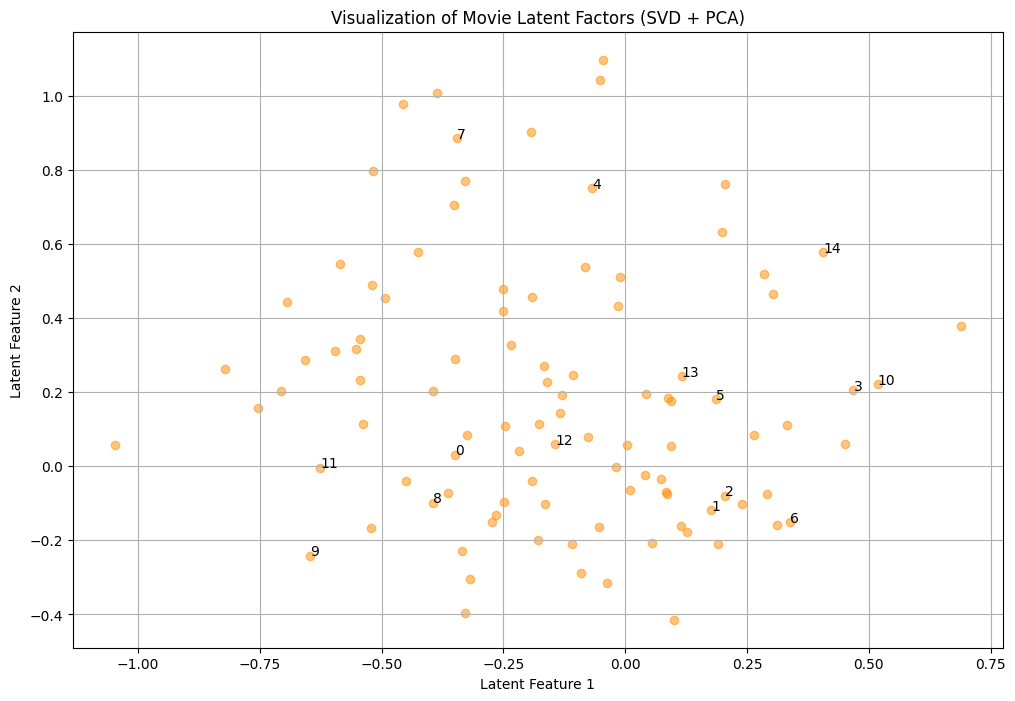

In [11]:
from sklearn.decomposition import PCA

# 1. Get the Item Matrix (Qi) from SVD
# This represents movies in a 'hidden' feature space
item_factors = svd_model.qi

# 2. Use PCA to reduce the features to 2 dimensions for plotting
pca = PCA(n_components=2)
reduced_factors = pca.fit_transform(item_factors)

# 3. Plot a sample of movies
plt.figure(figsize=(12, 8))
plt.scatter(reduced_factors[:100, 0], reduced_factors[:100, 1], alpha=0.5, color='darkorange')

# Annotate a few points so it looks professional
for i in range(15):
    plt.annotate(i, (reduced_factors[i, 0], reduced_factors[i, 1]))

plt.title('Visualization of Movie Latent Factors (SVD + PCA)')
plt.xlabel('Latent Feature 1')
plt.ylabel('Latent Feature 2')
plt.grid(True)
plt.show()

In [12]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

# Calculate for our SVD model
precisions, recalls = precision_recall_at_k(svd_preds, k=10, threshold=3.5)

# Precision and recall can then be averaged over all users
avg_precision = sum(prec_value for prec_value in precisions.values()) / len(precisions)
avg_recall = sum(rec_value for rec_value in recalls.values()) / len(recalls)

print(f"--- Final Ranking Metrics (SVD) ---")
print(f"Precision@10: {avg_precision:.4f}")
print(f"Recall@10:    {avg_recall:.4f}")

--- Final Ranking Metrics (SVD) ---
Precision@10: 0.7218
Recall@10:    0.3703
